In [1]:
# 1. Mount your Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install SimpleITK nibabel opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 22.0 MB/s eta 0:00:00


In [2]:
import os
import cv2

# === Input & Output Paths ===
INPUT_ROOT = '/content/drive/MyDrive/brain_tumor_dataset/Training'
OUTPUT_ROOT = '/content/drive/MyDrive/brain_tumor_dataset/CLAHE_jpg'

# === Create output subfolders ===
for class_name in os.listdir(INPUT_ROOT):
    input_class_path = os.path.join(INPUT_ROOT, class_name)
    output_class_path = os.path.join(OUTPUT_ROOT, class_name)
    if os.path.isdir(input_class_path):
        os.makedirs(output_class_path, exist_ok=True)

        # === Process each image in the class folder ===
        for img_name in os.listdir(input_class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_img_path = os.path.join(input_class_path, img_name)
                output_img_path = os.path.join(output_class_path, img_name)

                # Read in grayscale
                img = cv2.imread(input_img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                    enhanced_img = clahe.apply(img)
                    cv2.imwrite(output_img_path, enhanced_img)
        print(f" Done: {class_name}")



 Done: glioma_tumor
 Done: no_tumor
 Done: meningioma_tumor
 Done: pituitary_tumor


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import os


In [7]:
# Dataset path
DATA_DIR = '/content/drive/MyDrive/brain_tumor_dataset/CLAHE_jpg'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class labels:", class_names)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Class labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [8]:
# Normalize pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
# Load DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,220 (27.35 MB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import SGD

# Optional learning rate decay
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = SGD(
    learning_rate=lr_schedule,
    weight_decay=1e-5,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Optional: Save best model
checkpoint = ModelCheckpoint(
    'best_densenet_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3473 - loss: 1.6233

72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 674ms/step - accuracy: 0.3486 - loss: 1.6191 - val_accuracy: 0.6986 - val_loss: 0.7784
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5904 - loss: 0.9437

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5909 - loss: 0.9432 - val_accuracy: 0.7735 - val_loss: 0.6412
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6610 - loss: 0.8187

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6611 - loss: 0.8186 - val_accuracy: 0.7857 - val_loss: 0.5772
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6932 - loss: 0.7666

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6933 - loss: 0.7664 - val_accuracy: 0.8014 - val_loss: 0.5514
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6899 - loss: 0.7490

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6902 - loss: 0.7485 - val_accuracy: 0.8101 - val_loss: 0.5141
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6965 - loss: 0.6867

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6967 - loss: 0.6866 - val_accuracy: 0.8136 - val_loss: 0.5081
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7435 - loss: 0.6662 - val_accuracy: 0.8084 - val_loss: 0.5114
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7253 - loss: 0.6823

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7254 - loss: 0.6820 - val_accuracy: 0.8153 - val_loss: 0.4843
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7304 - loss: 0.6414

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7305 - loss: 0.6414 - val_accuracy: 0.8206 - val_loss: 0.4714
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7534 - loss: 0.6293 - val_accuracy: 0.8206 - val_loss: 0.4817
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7218 - loss: 0.6647 - val_accuracy: 0.8258 - val_loss: 0.4724
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7514 - loss: 0.6355

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7515 - loss: 0.6353 - val_accuracy: 0.8188 - val_loss: 0.4617
Epoch 13/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7404 - loss: 0.6375 - val_accuracy: 0.8188 - val_loss: 0.4711
Epoch 14/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7304 - loss: 0.6285

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7307 - loss: 0.6282 - val_accuracy: 0.8275 - val_loss: 0.4532
Epoch 15/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7774 - loss: 0.5758 - val_accuracy: 0.8293 - val_loss: 0.4571
Epoch 16/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7499 - loss: 0.6167

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.7499 - loss: 0.6165 - val_accuracy: 0.8345 - val_loss: 0.4395
Epoch 17/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7674 - loss: 0.5759 - val_accuracy: 0.8328 - val_loss: 0.4427
Epoch 18/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7696 - loss: 0.5845 - val_accuracy: 0.8223 - val_loss: 0.4495
Epoch 19/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7629 - loss: 0.5808

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7631 - loss: 0.5806 - val_accuracy: 0.8345 - val_loss: 0.4392
Epoch 20/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7540 - loss: 0.6089

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7543 - loss: 0.6085 - val_accuracy: 0.8397 - val_loss: 0.4371
Epoch 21/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7710 - loss: 0.5881

72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.7711 - loss: 0.5880 - val_accuracy: 0.8345 - val_loss: 0.4315
Epoch 22/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7864 - loss: 0.5624 - val_accuracy: 0.8432 - val_loss: 0.4318
Epoch 23/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7818 - loss: 0.5733 - val_accuracy: 0.8345 - val_loss: 0.4560
Epoch 24/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.7713 - loss: 0.5739 - val_accuracy: 0.8328 - val_loss: 0.4343
Epoch 25/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7856 - loss: 0.5557

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7857 - loss: 0.5555 - val_accuracy: 0.8310 - val_loss: 0.4310
Epoch 26/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7724 - loss: 0.5530

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.7726 - loss: 0.5528 - val_accuracy: 0.8328 - val_loss: 0.4282
Epoch 27/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7870 - loss: 0.5302 - val_accuracy: 0.8310 - val_loss: 0.4376
Epoch 28/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7719 - loss: 0.5599 - val_accuracy: 0.8275 - val_loss: 0.4558
Epoch 29/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7709 - loss: 0.5786

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7710 - loss: 0.5784 - val_accuracy: 0.8467 - val_loss: 0.4275
Epoch 30/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7737 - loss: 0.5573 - val_accuracy: 0.8328 - val_loss: 0.4339
Epoch 31/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7797 - loss: 0.5524 - val_accuracy: 0.8380 - val_loss: 0.4327
Epoch 32/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7845 - loss: 0.5602

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.7846 - loss: 0.5600 - val_accuracy: 0.8432 - val_loss: 0.4145
Epoch 33/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7876 - loss: 0.5519 - val_accuracy: 0.8328 - val_loss: 0.4165
Epoch 34/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7773 - loss: 0.5427 - val_accuracy: 0.8432 - val_loss: 0.4146
Epoch 35/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7806 - loss: 0.5595 - val_accuracy: 0.8328 - val_loss: 0.4318
Epoch 36/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7837 - loss: 0.5154 - val_accuracy: 0.8380 - val_loss: 0.4168
Epoch 37/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7923 - loss: 0.5432

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7924 - loss: 0.5429 - val_accuracy: 0.8502 - val_loss: 0.4087
Epoch 38/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7698 - loss: 0.5671 - val_accuracy: 0.8380 - val_loss: 0.4114
Epoch 39/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7864 - loss: 0.5505 - val_accuracy: 0.8345 - val_loss: 0.4205
Epoch 40/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7627 - loss: 0.5426 - val_accuracy: 0.8432 - val_loss: 0.4104
Epoch 41/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7875 - loss: 0.5377

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7876 - loss: 0.5374 - val_accuracy: 0.8449 - val_loss: 0.4068
Epoch 42/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7878 - loss: 0.5153 - val_accuracy: 0.8449 - val_loss: 0.4198
Epoch 43/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7994 - loss: 0.5123

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.7994 - loss: 0.5123 - val_accuracy: 0.8502 - val_loss: 0.4001
Epoch 44/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7946 - loss: 0.5168 - val_accuracy: 0.8449 - val_loss: 0.4122
Epoch 45/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7925 - loss: 0.5406 - val_accuracy: 0.8258 - val_loss: 0.4262
Epoch 46/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7962 - loss: 0.5143

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7963 - loss: 0.5142 - val_accuracy: 0.8554 - val_loss: 0.3986
Epoch 47/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8010 - loss: 0.5181 - val_accuracy: 0.8484 - val_loss: 0.4043
Epoch 48/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7788 - loss: 0.5148 - val_accuracy: 0.8362 - val_loss: 0.4075
Epoch 49/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8023 - loss: 0.5003 - val_accuracy: 0.8449 - val_loss: 0.3992
Epoch 50/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8047 - loss: 0.5112 - val_accuracy: 0.8467 - val_loss: 0.4011
Epoch 51/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7905 - loss: 0.5061

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.7905 - loss: 0.5061 - val_accuracy: 0.8554 - val_loss: 0.3914
Epoch 52/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7979 - loss: 0.5313 - val_accuracy: 0.8415 - val_loss: 0.3950
Epoch 53/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8002 - loss: 0.5112

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8001 - loss: 0.5110 - val_accuracy: 0.8519 - val_loss: 0.3857
Epoch 54/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8036 - loss: 0.5087 - val_accuracy: 0.8380 - val_loss: 0.4080
Epoch 55/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8037 - loss: 0.4946 - val_accuracy: 0.8415 - val_loss: 0.4015
Epoch 56/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7983 - loss: 0.5232 - val_accuracy: 0.8519 - val_loss: 0.3940
Epoch 57/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7973 - loss: 0.5181 - val_accuracy: 0.8258 - val_loss: 0.4074
Epoch 58/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8027 - loss: 0.4960 - val_accuracy: 0.8502 - val_loss: 0.3918


In [12]:
model.save('densenet_final_model.h5')


In [13]:
from google.colab import files
files.download('densenet_final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from google.colab import files
uploaded = files.upload()


Saving gg (110).jpg to gg (110).jpg


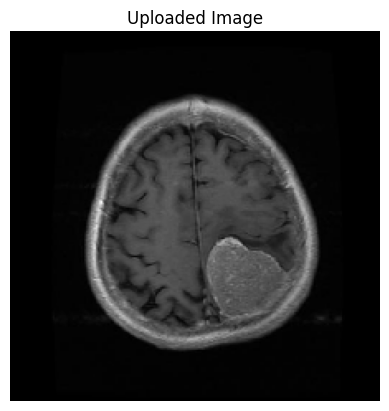

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Set image path
img_path = 'm (7).jpg'  # replace with your uploaded filename

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize

# Show image
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


In [ ]:
# Define class names manually (if lost)
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Predict
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]

print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Class: meningioma_tumor


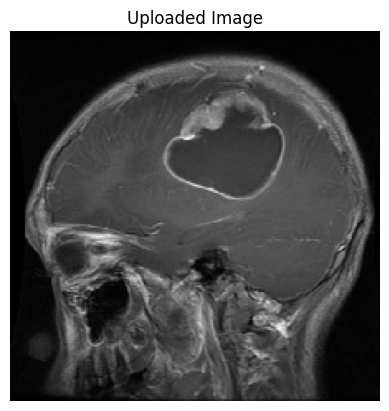

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Predicted Class: glioma_tumor


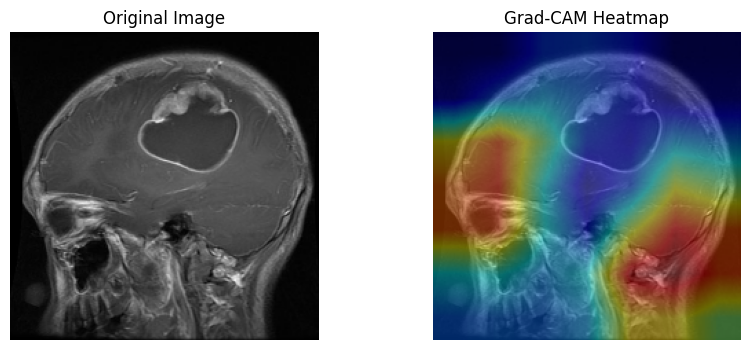

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing import image

# === STEP 1: Define your image filename ===
# Make sure the uploaded file name is correct here
img_path = 'gg (110).jpg'  # Replace with your uploaded filename

# === STEP 2: Load and preprocess image ===
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize

# Optional: show uploaded image
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()

# === STEP 3: Class prediction ===
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]
print(f"\nPredicted Class: {predicted_class}")

# === STEP 4: Grad-CAM Function Definitions ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at: {img_path}")
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

# === STEP 5: Generate and show Grad-CAM ===
last_conv_layer_name = "conv5_block16_2_conv"  # final conv layer in DenseNet121
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(img_path, heatmap)


In [14]:
!pip install optuna
!pip install optuna optuna-integration[tfkeras]

import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping


In [15]:
def build_model(trial):
    # Sample hyperparameters
    lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.3, 0.7)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    unfreeze_layers = trial.suggest_int("unfreeze_layers", 0, 50)

    # Load base model
    base_model = tf.keras.applications.DenseNet121(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    # Unfreeze last N layers
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    output = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [16]:
def objective(trial):
    model = build_model(trial)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, TFKerasPruningCallback(trial, 'val_accuracy')],
        verbose=0
    )

    val_acc = max(history.history["val_accuracy"])
    return val_acc


In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)  #10 crashes

print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-24 14:51:11,652] A new study created in memory with name: no-name-85778b4c-8068-4493-bc4f-0c59723e49ce
<ipython-input-15-2819eda7c6f0>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-15-2819eda7c6f0>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.3, 0.7)
[I 2025-04-24 14:53:26,255] Trial 0 finished with value: 0.693379819393158 and parameters: {'learning_rate': 3.291407799550572e-05, 'dropout_rate': 0.3631163237479678, 'dense_units': 256, 'unfreeze_layers': 23}. Best is trial 0 with value: 0.693379819393158.
[I 2025-04-24 14:55:31,702] Trial 1 fin

Best trial:
  Accuracy: 0.9042
  Params: 
    learning_rate: 0.006667652911632148
    dropout_rate: 0.4151511362222138
    dense_units: 256
    unfreeze_layers: 20


In [18]:
# Pull best parameters
best_params = study.best_trial.params

# Manually rebuild model using best parameters
def rebuild_best_model(params):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )

    for layer in base_model.layers[-params['unfreeze_layers']:]:
        layer.trainable = True
    for layer in base_model.layers[:-params['unfreeze_layers']]:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(params['dropout_rate'])(x)
    x = tf.keras.layers.Dense(params['dense_units'], activation="relu")(x)
    output = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    optimizer = tf.keras.optimizers.SGD(
        learning_rate=params['learning_rate'],
        momentum=0.9,
        nesterov=True
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Rebuild model with tuned hyperparameters
final_model = rebuild_best_model(best_params)

# Train again briefly to ensure it’s the latest version
final_model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 494ms/step - accuracy: 0.5761 - loss: 1.0162 - val_accuracy: 0.8240 - val_loss: 0.4928
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8385 - loss: 0.4382 - val_accuracy: 0.8606 - val_loss: 0.3593
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8800 - loss: 0.3221 - val_accuracy: 0.8833 - val_loss: 0.2808
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9122 - loss: 0.2453 - val_accuracy: 0.9077 - val_loss: 0.2409
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9385 - loss: 0.1742 - val_accuracy: 0.8902 - val_loss: 0.2939


In [21]:
final_model.save("densenet_optuna_final.h5")


In [22]:
from google.colab import files
files.download("densenet_optuna_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("densenet_optuna_final.h5")


In [24]:
from google.colab import files

# Upload a single image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # Get uploaded filename


Saving Huge_Meningioma.jpg to Huge_Meningioma.jpg


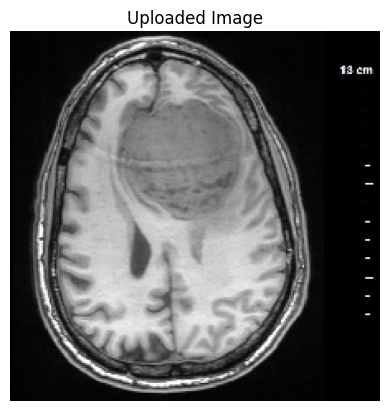

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and resize image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize to match training scale

# Show the image
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


In [26]:
# Your class names
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

print(f" Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
 Predicted Class: meningioma_tumor


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at: {img_path}")
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_7']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


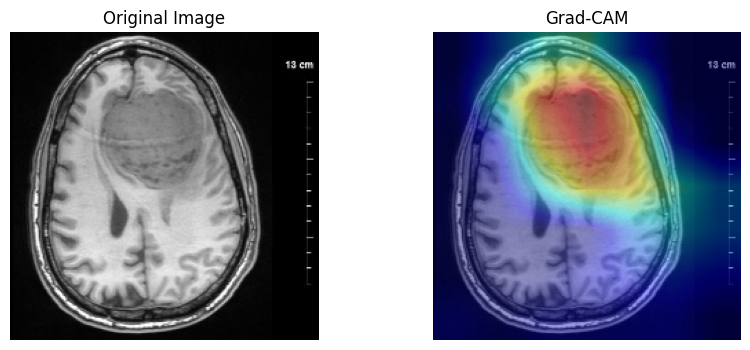

In [28]:
# This is the last conv layer of DenseNet121
last_conv_layer_name = "conv5_block16_2_conv"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display superimposed Grad-CAM
display_gradcam(img_path, heatmap)
